In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install tfa-nightly
!pip install tensorflow-addons
!pip install import-ipynb

     |████████████████████████████████| 1.1MB 8.1MB/s 
     |████████████████████████████████| 686kB 8.4MB/s 
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=9035860ff0bafa5cdc18d5c71030d36d7e8a0f615dbeaea0a7162a835e260e24
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import *
import tensorflow.keras.models as models
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import get_file
from tensorflow.keras.losses import mae
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops, math_ops, nn_ops, standard_ops
import os
import scipy.io as sio
import re
import time
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import glob
import sys
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep
%matplotlib inline
%cd /content/drive/MyDrive/Pix2Pix-for-Semantic-Segmentation-of-Satellite-Images/

/content/drive/.shortcut-targets-by-id/1Y_1PLKCUNVJAVLAZcJRgszel5vRSofus/Pix2Pix-for-Semantic-Segmentation-of-Satellite-Images


In [ ]:
# %run UnetModel.ipynb
# %run MumfordLoss.ipynb
# %run augmentation.ipynb
# %run augment_data.ipynb

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa

def flip(image,mask):
  
  if tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  
  if tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
  return image, mask
def brightness(image, mask):

  """
  Randomly applies a random brightness change.
  """
  cond_brightness = tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool)
  image = tf.cond(cond_brightness, lambda: tf.image.random_brightness(
      image, 0.2), lambda: tf.identity(image))
  return image, mask


def contrast(image, mask):

  """
  Randomly applies a random contrast change.
  """
  cond_contrast = tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool)
  image = tf.cond(cond_contrast, lambda: tf.image.random_contrast(
      image, 0.1, 0.8), lambda: tf.identity(image))
  return image, mask


def saturation(image, mask):

  """
  Randomly applies a random saturation change.
  """
  cond_saturation = tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool)
  image = tf.cond(cond_saturation, lambda: tf.image.random_saturation(
      image, 0.1, 0.5), lambda: tf.identity(image))
  return image, mask

def rotate_image(image, mask,angle=30):

  if tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool):
    comb = tf.concat([image,mask],axis=-1)
    comb = tfa.image.rotate(comb, angles=np.random.uniform(-angle, angle)*np.math.pi / 180)
    image,mask =  tf.split(comb, [image.shape[-1], mask.shape[-1]], axis=-1)
  return image, mask
def normalize(image,mask):
  image = tf.cast(image, tf.float32) / 255.0
  return image,mask

def gen_image_aug(image,mask):
  image, mask = brightness(image,mask)
  #image, mask = saturation(image,mask)
  image, mask = flip(image,mask)
  image, mask = rotate_image(image,mask)
  image, mask = normalize(image, mask)
  return image, mask

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-10):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true + y_pred, axis=axes)
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def jaccard_coef(y_true, y_pred, smooth=1e-10):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true + y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

In [ ]:
# #x =  np.load("Dataset/x_2018.npy")
# #y = np.load("Dataset/y_2018.npy")
# #from sklearn.model_selection import train_test_split
# #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state =42)
# x_train =  np.load("Dataset/x_train_2017.npy")
# x_train=tf.convert_to_tensor(x_train,tf.float32)

# y_train =  np.load("Dataset/y_train_2017.npy")
# y_train=tf.convert_to_tensor(y_train,tf.float32)

# x_test =  np.load("Dataset/x_test_2017.npy")
# x_test=tf.convert_to_tensor(x_test,tf.float32)

# y_test =  np.load("Dataset/y_test_2017.npy")
# y_test=tf.convert_to_tensor(y_test,tf.float32)


In [ ]:
# Dữ liệu:
# https://drive.google.com/drive/folders/1ey_xaLoqWAi7pRR9akBSjp6uqirPOpFQ?usp=sharing
data_folder='/content/drive/My Drive/Database/data_ISIC2017/data_ISIC2017/'
x_train= np.load(data_folder+'x_train2017_128.npy')
mask_train_0= np.load(data_folder+'y_train2017_128.npy')

x_test= np.load(data_folder+'x_test2017_128.npy')
mask_test_0= np.load(data_folder+'y_test2017_128.npy')
print(x_train.shape,mask_train_0.shape, mask_test_0.shape)

y_train=mask_train_0.reshape(mask_train_0.shape[0],mask_train_0.shape[1],mask_train_0.shape[2],1)
# mask_dev=mask_dev_0.reshape(mask_dev_0.shape[0],mask_dev_0.shape[1],mask_dev_0.shape[2],1)
y_test=mask_test_0.reshape(mask_test_0.shape[0],mask_test_0.shape[1],mask_test_0.shape[2],1)
print(x_train.shape,y_train.shape, y_test.shape)

(2000, 128, 128, 3) (2000, 128, 128) (600, 128, 128)


In [ ]:
# x_test_org=x_test
# y_test_org=y_test

In [ ]:
# y_train=mask_train_0.reshape(mask_train_0.shape[0],mask_train_0.shape[1],mask_train_0.shape[2],1)
# # mask_dev=mask_dev_0.reshape(mask_dev_0.shape[0],mask_dev_0.shape[1],mask_dev_0.shape[2],1)
# y_test=mask_test_0.reshape(mask_test_0.shape[0],mask_test_0.shape[1],mask_test_0.shape[2],1)
# print(x_train.shape,y_train.shape, y_test.shape)

(2000, 128, 128, 3) (2000, 128, 128, 1) (600, 128, 128, 1)


In [ ]:
x_train=tf.convert_to_tensor(x_train,tf.float32)
y_train=tf.convert_to_tensor(y_train,tf.float32)
x_test=tf.convert_to_tensor(x_test,tf.float32)
y_test=tf.convert_to_tensor(y_test,tf.float32)

In [ ]:
BATCH_SIZE = 32
buffer_size = x_train.shape[0]

@tf.function
def gen_image(image,mask):
  # image, mask = brightness(image,mask)
  #image, mask = saturation(image,mask)
  image, mask = flip(image,mask)
  image, mask = rotate_image(image,mask)
  image, mask = normalize(image, mask)
  return image, mask
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(buffer_size).map(gen_image).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).map(normalize).batch(BATCH_SIZE*2)
# val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val)).map(normalize).batch(BATCH_SIZE*2)

In [ ]:
# %run UnetModel_TT.ipynb

## Models

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Multiply, Concatenate
from keras.utils import np_utils
import tensorflow as tf
from keras.layers import Activation,BatchNormalization,Flatten,Conv2D,Lambda, add, average, Input, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, GlobalAveragePooling2D, Dense

from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Activation, add, UpSampling2D, Lambda, multiply
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn

In [ ]:
def up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])

    return concate
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'
    # theta_x(?,g_height,g_width,inter_channel)

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    # phi_g(?,g_height,g_width,inter_channel)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)

    # f(?,g_height,g_width,inter_channel)

    f = Activation('relu')(add([theta_x, phi_g]))

    # psi_f(?,g_height,g_width,1)

    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    # rate(?,x_height,x_width)

    # att_x(?,x_height,x_width,x_channel)

    att_x = multiply([x, rate])

    return att_x
def res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1],

              padding='same', data_format='channels_first'):
    data_format='channels_last'
    if data_format == 'channels_first':
        input_n_filters = input_layer.get_shape().as_list()[1]
    else:
        input_n_filters = input_layer.get_shape().as_list()[3]

    layer = input_layer
    for i in range(2):
        layer = Conv2D(out_n_filters // 4, [1, 1], strides=stride, padding=padding, data_format=data_format)(layer)
        if batch_normalization:
            layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)
        layer = Conv2D(out_n_filters // 4, kernel_size, strides=stride, padding=padding, data_format=data_format)(layer)
        layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(layer)

    if out_n_filters != input_n_filters:
        skip_layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(
            input_layer)
    else:
        skip_layer = input_layer
    out_layer = add([layer, skip_layer])
    return out_layer


In [ ]:
# Modify to work with LMS loss
def unet_modified(input_size = (128,128,3),classnum=2,pretrained_weights = None,):
    data = Input(shape=input_size, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)

    merge6 = attention_up_and_concate(conv5,conv4)
    conv6 = Conv2D(512, 3,  padding = 'same')(merge6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3,  padding = 'same')(conv6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)

    merge7 = attention_up_and_concate(conv6,conv3)
    conv7 = Conv2D(256, 3,  padding = 'same')(merge7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3,  padding = 'same')(conv7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)

    merge8 = attention_up_and_concate(conv7,conv2)
    conv8 = Conv2D(128, 3,  padding = 'same')(merge8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3,  padding = 'same')(conv8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)

    merge9 = attention_up_and_concate(conv8,conv1)
    conv9 = Conv2D(64, 3,  padding = 'same')(merge9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3,  padding = 'same')(conv9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(2, 3,  padding = 'same')(conv9)
    conv9 = Activation('relu')(conv9)
    conv10 = Conv2D(classnum, 1, activation = 'softmax')(conv9) #modify this
     # If Dice loss: conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(data, conv10)

    # model.compile(optimizer = SGD(lr = 0.01,momentum=0.9), loss = focal_tversky, metrics = ['accuracy',dice_coef])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import keras.backend as K
class Swish(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, inputs, **kwargs):
        return tf.nn.swish(inputs)

    def get_config(self):
        config = super().get_config()
        config['name'] = self.name
        return config
def squeeze_excite_block(reduce_ratio=0.25,name_block=None):
  def call(inputs):
    filters = inputs.shape[-1]
    num_reduced_filters= max(1, int(filters * reduce_ratio))
    se = Lambda(lambda a: K.mean(a, axis=[1,2], keepdims=True))(inputs)

    se = Conv2D(
            num_reduced_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer='he_normal',
            padding='same',
            use_bias=True
        )(se)
    se = Swish()(se)
    se = Conv2D(
            filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer='he_normal',
            padding='same',
            use_bias=True
        )(se)
    se = Activation('sigmoid')(se)
    if name_block is not None:
      out = Multiply(name=name_block)([se, inputs])
    else : 
      out = Multiply()([se, inputs])
    return out
  return call

def conv_block(filters,kernel_size = (3,3), dilation = 1,block_name=None):
  def call(inputs):
    x = inputs

    x = Conv2D(filters, kernel_size, padding="same",dilation_rate =dilation ,use_bias=False,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Swish()(x)

    x = Conv2D(filters, kernel_size, padding="same",dilation_rate =dilation, use_bias=False,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Swish()(x)

    x = squeeze_excite_block(name_block=block_name)(x)

    return x
  return call


def decoder_block(n_filter,skip=None):
  def call(inputs):
    x= Conv2DTranspose(n_filter, (2,2), strides=(2, 2), padding='same',kernel_initializer = 'he_normal')(inputs)
    out = x
    if skip is not None :
      attention = conv_block(n_filter)(skip)
      out = Concatenate()([x,attention])
    out = conv_block(n_filter)(out)

    return out
  return call
def dow_block(kernel_size=(2,2),stride=(2,2)):
  def call(inputs):
    out = MaxPooling2D(kernel_size, strides=stride)(inputs)
    return out
  return call

def encoderSegnet(input_s=(128,128,1)):
  down_block = dow_block()
  inp= Input(shape=input_s)
  o = inp
  nums_filter=[64,128,256,512,512]
  count=0
  for f in nums_filter[:-1]:
    count+=1
    o = conv_block(f,block_name='output_block_'+str(count))(o)
    o = down_block(o)

  o = conv_block(nums_filter[-1],block_name='output_block_'+str(count+1))(o)
  #o = Dropout(0.5)(o)
  return Model(inp,o)  
list_skip = ["output_block_4", "output_block_3", "output_block_2", "output_block_1"]


In [ ]:
def u_net1(input_size=(192,256,3), out_channels=3):
  # encoder = encoderSegnet(input_s = input_size)
  data = Input(shape=input_size, dtype='float', name='data')
  mvn0 = Lambda(mvn)(data)
  conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
  conv1 = Lambda(mvn)(conv1)
  conv1 = Activation('relu')(conv1)
  conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
  conv1 = Lambda(mvn)(conv1)
  conv1 = Activation('relu')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
  conv2 = Lambda(mvn)(conv2)
  conv2 = Activation('relu')(conv2)
  conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
  conv2 = Lambda(mvn)(conv2)
  conv2 = Activation('relu')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
  conv3 = Lambda(mvn)(conv3)
  conv3 = Activation('relu')(conv3)
  conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
  conv3 = Lambda(mvn)(conv3)
  conv3 = Activation('relu')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
  conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
  conv4 = Lambda(mvn)(conv4)
  conv4 = Activation('relu')(conv4)
  conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
  conv4 = Lambda(mvn)(conv4)
  conv4 = Activation('relu')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
  conv5 = Lambda(mvn)(conv5)
  conv5 = Activation('relu')(conv5)
  conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
  conv5 = Lambda(mvn)(conv5)
  conv5 = Activation('relu')(conv5)
  drop5 = Dropout(0.5)(conv5)

  merge6 = attention_up_and_concate(conv5,conv4)
  conv6 = Conv2D(512, 3,  padding = 'same')(merge6)
  conv6 = Lambda(mvn)(conv6)
  conv6 = Activation('relu')(conv6)
  conv6 = Conv2D(512, 3,  padding = 'same')(conv6)
  conv6 = Lambda(mvn)(conv6)
  conv6 = Activation('relu')(conv6)

  merge7 = attention_up_and_concate(conv6,conv3)
  conv7 = Conv2D(256, 3,  padding = 'same')(merge7)
  conv7 = Lambda(mvn)(conv7)
  conv7 = Activation('relu')(conv7)
  conv7 = Conv2D(256, 3,  padding = 'same')(conv7)
  conv7 = Lambda(mvn)(conv7)
  conv7 = Activation('relu')(conv7)

  merge8 = attention_up_and_concate(conv7,conv2)
  conv8 = Conv2D(128, 3,  padding = 'same')(merge8)
  conv8 = Lambda(mvn)(conv8)
  conv8 = Activation('relu')(conv8)
  conv8 = Conv2D(128, 3,  padding = 'same')(conv8)
  conv8 = Lambda(mvn)(conv8)
  conv8 = Activation('relu')(conv8)

  merge9 = attention_up_and_concate(conv8,conv1)
  conv9 = Conv2D(64, 3,  padding = 'same')(merge9)
  conv9 = Lambda(mvn)(conv9)
  conv9 = Activation('relu')(conv9)
  conv9 = Conv2D(64, 3,  padding = 'same')(conv9)
  conv9 = Lambda(mvn)(conv9)
  conv9 = Activation('relu')(conv9)
  conv9 = Conv2D(2, 3,  padding = 'same')(conv9)
  conv9 = Activation('relu')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  # model = Model(data, conv10)

    # model.compile(optimizer = SGD(lr = 0.01,momentum=0.9), loss = focal_tversky, metrics = ['accuracy',dice_coef])
    
    #model.summary()

  # o = Conv2D(out_channels,(3, 3), padding='same', kernel_initializer='he_normal')(conv10)
  # yn = Activation('softmax')(o[...,:-1])
  # bn = o[...,-1:]
  # output = Concatenate()([yn,bn])
  # if out_channels > 1 : 
  #   output = Activation('softmax', name = 'softmax')(o)
  # else :
  #   output = Activation('sigmoid', name = 'sigmoid')(o)
  return Model(data,conv10) 


## Not tested yet

In [ ]:
#Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)
def r2unet(input_size = (192,288,3),classnum=2,pretrained_weights = None,):
    data_format='channels_last'
    data = Input(shape=input_size, dtype='float', name='data')
    x = data
    depth = 4
    features = 64
    skips = []
    for i in range(depth):
        x = rec_res_block(x, features, data_format=data_format)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format=data_format)(x)

        features = features * 2

    x = rec_res_block(x, features, data_format=data_format)

    for i in reversed(range(depth)):
        features = features // 2
        x = up_and_concate(x, skips[i], data_format=data_format)
        x = rec_res_block(x, features, data_format=data_format)

    conv6 = Conv2D(classnum, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = Activation('sigmoid')(conv6)
    model = Model(data,conv7)
    # model = Model(inputs=inputs, outputs=conv7)

    # conv6 =Conv2D(classnum, (1, 1), padding='same', data_format=data_format)(x)
    # conv7=Activation('softmax')(conv6)
    # model = Model(data,conv7)


    #model.compile(optimizer=Adam(lr=1e-6), loss=[dice_coef_loss], metrics=['accuracy', dice_coef])
    return model

In [ ]:
#Attention R2U-Net
def att_r2unet(input_size = (192,288,3), out_channels=2):
    data_format='channels_last'
    data = Input(shape=input_size, name='data')
    x = data
    depth = 4
    features = 64
    skips = []
    for i in range(depth):
        x = rec_res_block(x, features, data_format=data_format)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format=data_format)(x)

        features = features * 2

    x = rec_res_block(x, features, data_format=data_format)

    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = rec_res_block(x, features, data_format=data_format)

    # conv6 = Conv2D(out_channels, (1, 1), padding='same', data_format=data_format)(x)
    # conv6 = Activation('softmax')(conv6)
    # model = Model(data, conv6)
    conv6 =Conv2D(out_channels, (1, 1), padding='same', data_format=data_format)(x)
    conv7=Activation('softmax')(conv6)
    model = Model(data,conv7)


    #model.compile(optimizer=Adam(lr=1e-6), loss=[dice_coef_loss], metrics=['accuracy', dice_coef])
    return model

In [ ]:
# S = att_unet(input_size = (192,288,3),classnum=2)# not tested yet
# S = att_r2unet(input_size = (128,128,3), out_channels=2)# not tested yet
# S = r2unet(input_size = (192,288,3),classnum=2)
S = r2unet(input_size = (128,128,3),classnum=2)
nhat = Mumford_Unet_vs2(S)
nhat.learning_rate = 0.001
nhat.trainData = train_dataset
nhat.testData = test_dataset
nhat.optimizer_fc(op_type = "nadam", op_param=nhat.learning_rate)

## Train by LMS loss

In [ ]:
class MSLoss_vs2():
  def levelsetLoss(self,target, output):
    loss = 0.0
    for ich in range(target.shape[3]):
        target_ = target[...,ich:ich+1]    
        pcentroid = tf.reduce_sum(target_ * output, (1,2),keepdims=True)/tf.reduce_sum(output, (1,2),keepdims = True)   
        plevel = target_ - pcentroid
        pLoss = plevel * plevel * output
        loss += tf.reduce_sum(pLoss)
    return loss
      
  def activeContourLoss(self,y_true,y_pred,outDim =2,smooth=0.001):     
    yTrueOnehot = tf.one_hot(tf.squeeze(tf.cast(y_true,tf.uint8),axis=-1), depth = outDim)
    loss =  y_pred * (1-yTrueOnehot) + (1-y_pred)*yTrueOnehot
    return tf.reduce_mean(loss)
    #this is Luac:
    # loss =  - tf.cast(tf.math.log(1-y_pred+smooth),tf.float32) * (1-yTrueOnehot ) - tf.cast(tf.math.log(y_pred+smooth),tf.float32)*yTrueOnehot
    # return tf.reduce_mean(loss)
                    
  def gradientLoss(self,input,penalty = "l1"):

    dH = tf.math.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = tf.math.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    if penalty == "l2":
        dH = dH * dH
        dW = dW * dW

    loss =  tf.reduce_sum(dH) +  tf.reduce_sum(dW)
    return loss

In [ ]:
class Mumford_Unet_vs2(MSLoss_vs2):
  def __init__(self,model):
    super().__init__()
    self.model = model
    self.optimizer = None
    self.trainData = None
    self.testData = None
    self.batch_size = BATCH_SIZE
    temp = x_train.shape[0] // self.batch_size
    self.train_step = temp + 1 if x_train.shape[0] % self.batch_size != 0 else temp
    self.learning_rate = 0.001

  def optimizer_fc(self,op_type = "adam", op_param = 0.005):
    if op_type == 'adam':
      self.optimizer =  tf.keras.optimizers.Adam(op_param)
    elif op_type == "nadam":
      self.optimizer =  tf.keras.optimizers.Nadam(op_param)

  def loss(self, image, output, trueLabel, alpha = 1e-3, beta = 0.001):
    print('\ractive loss: ',self.activeContourLoss(trueLabel, output),' leverset loss: ', self.levelsetLoss(image,output),'gradient loss: ', self.gradientLoss(output), end="")
    return alpha * ( self.levelsetLoss(image,output) + beta * self.gradientLoss(output)) + self.activeContourLoss(trueLabel, output)
    # return self.activeContourLoss(trueLabel, output)

  def metrics(self,y_true,y_pred):
    output_standard = tf.expand_dims(tf.argmax(y_pred,axis=-1),axis = -1)
    output_standard = tf.cast(output_standard,tf.float32)
    dice = dice_coef(y_true, output_standard)
    jaccard = jaccard_coef(y_true, output_standard)
    return dice, jaccard

  def evaluateTest(self,testDataset):
    test_dices =  []
    test_jaccards =  []
    for xBatchTest, yBatchTest in testDataset:
      yPredBatchTest = self.model(xBatchTest, training =False)
      diceTest, jaccardTest =  self.metrics(yBatchTest, yPredBatchTest)
      test_dices.append(diceTest)
      test_jaccards.append(jaccardTest)
    return np.mean(test_dices), np.mean(test_jaccards)

  def epoch_training(self,model,optimizer, trainDataset, testDataset, mb, stepTrain, alpha_loss, beta_loss):
    train_losses = []
    train_dices =  []
    train_jaccards =  []

    trainDataset = iter(trainDataset)  
    for _ in progress_bar(range(stepTrain),parent = mb):   
      with tf.GradientTape() as tape:
        image, y_true = next(trainDataset)
        y_pred = self.model(image, training = True)
        total_loss  =  self.loss(image, y_pred, y_true, alpha_loss, beta_loss)

      
      grad  = tape.gradient(total_loss, self.model.trainable_variables)
      optimizer.apply_gradients(zip(grad,self.model.trainable_variables))

      diceTrain, jaccardTrain =  self.metrics(y_true, y_pred)

      mb.child.comment = 'Train loss {:.4f}'.format(total_loss)

      train_losses.append(total_loss)
      train_dices.append(diceTrain)
      train_jaccards.append(jaccardTrain)

    trainLossMean = np.mean(train_losses)
    trainDiceMean = np.mean(train_dices)
    trainJaccardMean = np.mean(train_jaccards)

    testDiceMean, testJaccardMean = self.evaluateTest(testDataset)

    return trainLossMean, trainDiceMean, trainJaccardMean, testDiceMean, testJaccardMean


  def train(self,num_epoch, reduceLrEpoch=10 , earlyStoping=22, minLr=1e-5, alpha_loss= 1e-6, beta_loss = 1,checkpoint_prefix = "m"):
    mb = master_bar(range(num_epoch))
    epochs_list = []
    history = dict()
    training_losses = []
    trainDice_list = []
    trainJaccard_list = []
    testDice_list = []
    testJaccard_list = []
    # learningRate_list = []
    best_score  = 0
    count = 0
    for epoch in mb:
      count += 1
      epochs_list.append(epoch+1)

      trainLoss, trainDice, trainJaccard, testDice, testJaccard  \
      = self.epoch_training(self.model, self.optimizer, self.trainData, self.testData, mb, self.train_step, alpha_loss, beta_loss)

      mb.write('Finish train epoch {} with loss {:.4f} trainDice: {:.4f}, trainJaccard: {:.4f}, testDice: {:.4f},\
       testJaccard: {:.4f}'.format(epoch+1, trainLoss, trainDice, trainJaccard, testDice, testJaccard))

      training_losses.append(trainLoss)
      trainDice_list.append(trainDice)
      trainJaccard_list.append(trainJaccard)
      testDice_list.append(testDice)
      testJaccard_list.append(testJaccard)
      # learningRate_list.append(self.learning_rate)

      if count % reduceLrEpoch ==0 :
        self.learning_rate = self.learning_rate * 0.5
        if self.learning_rate < minLr:
          self.learning_rate = minLr
        print('learning rate is set to : ',self.learning_rate)
        self.optimizer.learning_rate.assign(self.learning_rate )
    
      mb.update_graph([[epochs_list, training_losses]], [0,num_epoch], [0,0.1])
      if count == earlyStoping :
        break
      ### Check point here ###
      ### Check point follow testDice ###
      if best_score < testDice:
          count = 0
          mb.write(">>> Improved Dice-score from {:.4f} to {:.4f}".format(best_score, testDice))
          best_score = testDice
          self.model.save_weights(checkpoint_prefix.format(score=best_score))
    history['epoch'] = epochs_list
    history['train_loss'] = training_losses
    history['train_dice'] = trainDice_list
    history['train_jaccard'] = trainJaccard_list
    history['test_dice'] = testDice_list
    history['test_jaccard'] = testJaccard_list
    # history['lr'] = learningRate_list
    return history 

In [ ]:
S = unet_modified((128,128,3),classnum=2)
nhat = Mumford_Unet_vs2(S)
nhat.learning_rate = 0.001
nhat.trainData = train_dataset
nhat.testData = test_dataset
nhat.optimizer_fc(op_type = "nadam", op_param=nhat.learning_rate)

active loss:  tf.Tensor(0.20847811, shape=(), dtype=float32)  leverset loss:  tf.Tensor(0.8824639, shape=(), dtype=float32) gradient loss:  tf.Tensor(7351.7295, shape=(), dtype=float32)

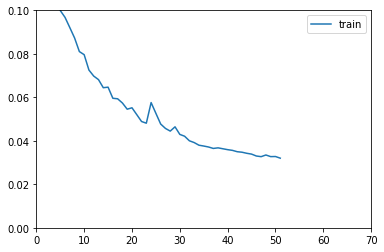

active loss:  tf.Tensor(0.044448107, shape=(), dtype=float32)  leverset loss:  tf.Tensor(0.6633963, shape=(), dtype=float32) gradient loss:  tf.Tensor(6827.7246, shape=(), dtype=float32)learning rate is set to :  0.0005
active loss:  tf.Tensor(0.028703975, shape=(), dtype=float32)  leverset loss:  tf.Tensor(0.441951, shape=(), dtype=float32) gradient loss:  tf.Tensor(6594.8237, shape=(), dtype=float32)learning rate is set to :  0.00025
active loss:  tf.Tensor(0.026260927, shape=(), dtype=float32)  leverset loss:  tf.Tensor(0.6209923, shape=(), dtype=float32) gradient loss:  tf.Tensor(8930.648, shape=(), dtype=float32)

In [ ]:
import shutil
file_name = 'weight_LMS_loss_unet'
if os.path.exists(file_name):
  shutil.rmtree(file_name)  
os.mkdir(file_name)
history = nhat.train(70,alpha_loss=1e-6,beta_loss=1e-2,checkpoint_prefix="./weight_LMS_loss_unet/ckpt_{score:.4f}.h5")
sio.savemat('isic17_LMS_Unet.mat',history)
nhat.evaluateTest(test_dataset)

In [ ]:
# nhat.model.load_weights('weight_isic17_MS_ckpt_0.8463.h5')
x_test_org= np.load(data_folder+'x_test2017_128.npy')
y_test_org= np.load(data_folder+'y_test2017_128.npy')
nhat.evaluateTest(test_dataset)
model1=nhat.model
y_pred_all=model1.predict(x_test_org)
import scipy.io as sio
sio.savemat('Result_isic17_LMS_Unet.mat'
            , {'history': history, 'y_pred_all': y_pred_all, 'x_test': x_test_org, 'y_test': y_test_org})


## Dice loss

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-10):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true + y_pred, axis=axes)
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def jaccard_coef(y_true, y_pred, smooth=1e-10):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true + y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)
def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, 0.0)

In [ ]:
S1=u_net1((128,128,3),out_channels=2)


In [ ]:
S1.compile(loss = dice_coef_loss,optimizer=tf.keras.optimizers.Nadam(0.001),metrics=[dice_coef, jaccard_coef])

In [ ]:
import shutil
file_name = 'weight_Dice_loss_unet'
if os.path.exists(file_name):
  shutil.rmtree(file_name)  
os.mkdir(file_name)

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
mcp = ModelCheckpoint("./weight_Dice_loss_unet/weight_{val_dice_coef:.4f}.h5",mode='max',monitor='val_dice_coef',verbose=1,save_best_only=True,save_weights_only=True)
earlystop= EarlyStopping(monitor='val_dice_coef',patience=30,mode='max',verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, mode='max', patience=50, min_lr=1e-6, verbose=1)
history = S1.fit(train_dataset,validation_data=test_dataset,
	    epochs=300,callbacks=[earlystop,mcp],verbose=1)

sio.savemat('./weight_Dice_loss_unet/historyISIC_UnetBase.mat',history)

In [ ]:
# # nhat.model.load_weights('weight_NewLoss_r2unet/ckpt_.h5')

# nhat.evaluateTest(test_dataset)
# model1=nhat.model
# y_pred_all=model1.predict(x_test)
# import scipy.io as sio
# sio.savemat('Result_isic17_newLoss_r2unet.mat'
#             , {'history': history, 'y_pred_all': y_pred_all, 'x_test': x_test, 'y_test': y_test})


In [ ]:
# history = nhat.train(70,alpha_loss=1e-6,beta_loss=1e-2,checkpoint_prefix="/content/drive/MyDrive/Pix2Pix-for-Semantic-Segmentation-of-Satellite-Images/_checkpoint/ckpt_{score:.4f}.h5")

In [ ]:
# sio.savemat('/content/drive/MyDrive/Pix2Pix-for-Semantic-Segmentation-of-Satellite-Images/_checkpoint/history.mat',history)

In [ ]:
# nhat.model.load_weights('/content/drive/MyDrive/LMSLoss/weightISIC_MS/ckpt_0.8829.h5')

In [ ]:
# nhat.evaluateTest(test_dataset)

In [ ]:
# for i in range(x_test.shape[0]):
#   y_pred = nhat.model(normalize(x_test[i:i+1],y_test[i:i+1]))
#   y_predShow = np.argmax(y_pred,axis = -1)
#   plt.figure(i+1)
#   plt.subplot(131),plt.imshow(x_test[i]),plt.title('image')
#   plt.subplot(132),plt.imshow(y_predShow[0],cmap ='gray'),plt.title('predict')
#   plt.subplot(133),plt.imshow(y_test[i,...,0],cmap='gray'),plt.title('groundtruth')